In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample = 500000
shift = 0; beta = 0;

# alpha, rho, nu
params = np.random.random_sample((sample,3))*[1.49999, 1.96, 0.69999] + [0.00001, -0.98, 0.00001]

T = np.random.randint(1,30,sample)
F0 = np.random.random_sample(sample)*0.0299 + 0.0201
Kpb = np.linspace(-200,200,9); K = []
for i in range(len(F0)):
    K.append(F0[i] + Kpb/10000)

In [11]:
### GENERATE THE SABR VOLS ###

import SABRnormal
vol_input = []
for i in range(sample):
    vol_input_ind = []
    for j in range(len(Kpb)):
        aux = SABRnormal.normal_vol(K[i][j],F0[i],T[i],params[i][0],beta,params[i][1],params[i][2],shift)
        vol_input_ind.append(aux)
    vol_input.append(vol_input_ind)

In [12]:
### Create the matrix of inputs ###
K = np.matrix(K); vol_input = np.matrix(vol_input)
# The order is: [K (vector of strikes), sigma (vector of vols), F0, T]
X = np.hstack((K,np.matrix(F0).T,vol_input,np.matrix(T).T))

# Create data input and output for neural network
# The output to predict will be the parameters alpha, rho, nu
X_train = X[:int(0.8*sample)]; X_test = X[int(0.8*sample):]
y_train = params[:int(0.8*sample)]; y_test = params[int(0.8*sample):]

#plt.figure()
#plt.plot(K[0][:],vol_input[0][:],'rx');

from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [13]:
### NEURAL NETWORK ###
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers

model = Sequential()
model.add(Dense(256, activation='elu', input_dim = 20, kernel_initializer='he_uniform'))
model.add(Dense(128, activation='elu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='elu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='elu', kernel_initializer='he_uniform'))
model.add(Dense(3))

#model.add(Dense(30, activation='elu', input_dim = 20, kernel_initializer='he_uniform'))
#model.add(Dense(30, activation='elu',  kernel_initializer='he_uniform'))
#model.add(Dense(30, activation='elu', kernel_initializer='he_uniform'))
#model.add(Dense(30, activation='elu', kernel_initializer='he_uniform'))
#model.add(Dense(3))

sgd = keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=sgd,
              metrics=['mae'])  

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [14]:
epochs = 100
batch_size = 128
### Fit the model weights ###
# Introduce Early Stopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=8, verbose=1)
# Reduce Learning Rate when val_loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, cooldown = 1, min_lr=0.0001)
# Record on Tensorboard all the information
#tboard = TensorBoard(log_dir = './logs', histogram_freq = 5, batch_size = batch_size,
#                          update_freq='epoch')


history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = [reduce_lr, earlystop]
          )

Instructions for updating:
Use tf.cast instead.
Train on 400000 samples, validate on 100000 samples
Epoch 1/100
400000/400000 [==============================] - 14s 35us/step - loss: 0.1102 - mean_absolute_error: 0.2301 - val_loss: 0.0596 - val_mean_absolute_error: 0.1716
Epoch 2/100
400000/400000 [==============================] - 13s 34us/step - loss: 0.0515 - mean_absolute_error: 0.1555 - val_loss: 0.0416 - val_mean_absolute_error: 0.1388
Epoch 3/100
400000/400000 [==============================] - 15s 36us/step - loss: 0.0420 - mean_absolute_error: 0.1390 - val_loss: 0.0309 - val_mean_absolute_error: 0.1198
Epoch 4/100
400000/400000 [==============================] - 14s 35us/step - loss: 0.0390 - mean_absolute_error: 0.1340 - val_loss: 0.0420 - val_mean_absolute_error: 0.1391
Epoch 5/100
400000/400000 [==============================] - 15s 37us/step - loss: 0.0374 - mean_absolute_error: 0.1315 - val_loss: 0.0623 - val_mean_absolute_error: 0.1672
Epoch 6/100
400000/400000 [========

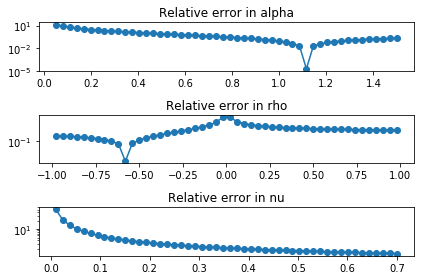

In [15]:
## TEST WINDOW ##

F0 = 0.03; Ktest = F0 + Kpb/10000; T = 5; beta = 0; shift = 0;

rho = 0.4; nu = 0.3; alphaaux = np.linspace(0.05,1.5, 50); param0 = []
for i in range(len(alphaaux)):
    vol_input_ind = []
    for j in range(len(Kpb)):
        aux = SABRnormal.normal_vol(Ktest[j],F0,T,alphaaux[i],beta,rho,nu,shift)
        vol_input_ind.append(aux)
    Xaux = np.hstack((Ktest,F0,vol_input_ind,T))
    Xaux = Xaux.reshape(1,-1)
    paramspred = model.predict(Xaux)
    param0.append(paramspred[0][0])

alpha = 0.8; nu = 0.3; rhoaux = np.linspace(-0.98,0.98, 50); param1 = []
for i in range(len(rhoaux)):
    vol_input_ind = []
    for j in range(len(Kpb)):
        aux = SABRnormal.normal_vol(Ktest[j],F0,T,alpha,beta,rhoaux[i],nu,shift)
        vol_input_ind.append(aux)
    Xaux = np.hstack((Ktest,F0,vol_input_ind,T))
    Xaux = Xaux.reshape(1,-1)
    paramspred = model.predict(Xaux)
    param1.append(paramspred[0][1])

alpha = 0.8; rho = 0.4; nuaux = np.linspace(0.01,0.7, 50); param2 = []
for i in range(len(nuaux)):
    vol_input_ind = []
    for j in range(len(Kpb)):
        aux = SABRnormal.normal_vol(Ktest[j],F0,T,alpha,beta,rho,nuaux[i],shift)
        vol_input_ind.append(aux)
    Xaux = np.hstack((Ktest,F0,vol_input_ind,T))
    Xaux = Xaux.reshape(1,-1)
    paramspred = model.predict(Xaux)
    param2.append(paramspred[0][1])


plt.subplot(311)
plt.plot(alphaaux,np.abs((param0-alphaaux)/alphaaux),'o-'); plt.title('Relative error in alpha');
plt.yscale('log')

plt.subplot(312)
plt.plot(rhoaux,np.abs((param1-rhoaux)/rhoaux),'o-'); plt.title('Relative error in rho');
plt.yscale('log')

plt.subplot(313)
plt.plot(nuaux,np.abs((param2-nuaux)/nuaux),'o-'); plt.title('Relative error in nu');
plt.yscale('log')
plt.tight_layout()
plt.show()